In [259]:
import numpy as np
import pandas as pd

df=pd.read_csv('resampled_data.csv')
#df.drop(columns=['DIQ010','RIAGENDR','BMXBMI'], inplace=True)

df.head()

,RIAGENDR,PAQ605,BMXBMI,LBXGLU,DIQ010,LBXGLT,LBXIN,age_group
0,2.0,2.0,35.7,110.0,2.000000,150.0,14.91,0
1,2.0,2.0,20.3,89.0,2.000000,80.0,3.85,0
2,1.0,2.0,23.2,89.0,2.000000,68.0,6.14,0
3,1.0,2.0,28.9,104.0,2.015512,84.0,16.15,0
4,2.0,1.0,35.9,103.0,2.000000,81.0,10.92,0


In [260]:
# 4. Feature engineering: add new features here
import pandas as pd
import numpy as np


df['log_LBXGLT'] = np.log1p(df['LBXGLT'])
# 2. BMI feature engineering
#df['BMXBMI_squared'] = df['BMXBMI'] ** 2

# BMI medical categories and encoding
#bmi_bins = [0, 18.5, 25, 30, np.inf]
#bmi_labels = ['underweight', 'normal', 'overweight', 'obese']
#df['BMI_category'] = pd.cut(df['BMXBMI'], bins=bmi_bins, labels=bmi_labels)
#df['BMI_category_encoded'] = df['BMI_category'].map({
#    'underweight': 0, 'normal': 1, 'overweight': 2, 'obese': 3
#})
#df.drop(columns=['BMI_category'], inplace=True)
df['LBX']=df['LBXGLT']+df['LBXGLU']
# Senior risk indicator (BMI >= 25)
df['BMI_senior_risk'] = (df['BMXBMI'] >= 25).astype(int)

df['random']=df['DIQ010']+df['LBXIN']+df['BMXBMI']+df['RIAGENDR']

# BMI missingness indicator
#df['BMXBMI_missing'] = df['BMXBMI'].isnull().astype(int)

# 3. Interactions (optional, if PAQ605 exists)
if 'PAQ605' in df.columns:
    df['BMI_activity_interaction'] = df['BMXBMI'] * df['PAQ605']


# 4. Drop any remaining non-numeric columns except your target
for col in df.select_dtypes(include='object').columns:
    if col != 'age_group':  # Keep target if it's still object
        df = pd.get_dummies(df, columns=[col], prefix=col, drop_first=True)
df.drop(columns=['BMXBMI','DIQ010','LBXIN','RIAGENDR'], inplace=True)
print(df.head())


   PAQ605  LBXGLU  LBXGLT  age_group  log_LBXGLT    LBX  BMI_senior_risk  \
0     2.0   110.0   150.0          0    5.017280  260.0                1   
1     2.0    89.0    80.0          0    4.394449  169.0                0   
2     2.0    89.0    68.0          0    4.234107  157.0                0   
3     2.0   104.0    84.0          0    4.442651  188.0                1   
4     1.0   103.0    81.0          0    4.406719  184.0                1   

      random  BMI_activity_interaction  
0  54.610000                      71.4  
1  28.150000                      40.6  
2  32.340000                      46.4  
3  48.065512                      57.8  
4  50.820000                      35.9  


In [261]:
from sklearn.model_selection import train_test_split

# Feature columns (excluding 'age_group' and 'SEQN' if it's just an ID)
feature_cols = [col for col in df.columns if col not in ['SEQN', 'age_group']]
X = df[feature_cols]
y = df['age_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [262]:
!pip install xgboost


Random Forest Results:
Accuracy: 0.8795731707317073
F1 Score: 0.8731942215088283
              precision    recall  f1-score   support

           0       0.90      0.87      0.89       351
           1       0.86      0.89      0.87       305

    accuracy                           0.88       656
   macro avg       0.88      0.88      0.88       656
weighted avg       0.88      0.88      0.88       656


SVM Results:
Accuracy: 0.7027439024390244
F1 Score: 0.6839546191247974
              precision    recall  f1-score   support

           0       0.73      0.71      0.72       351
           1       0.68      0.69      0.68       305

    accuracy                           0.70       656
   macro avg       0.70      0.70      0.70       656
weighted avg       0.70      0.70      0.70       656


Logistic Regression Results:
Accuracy: 0.7179878048780488
F1 Score: 0.7086614173228346
              precision    recall  f1-score   support

           0       0.75      0.70      0.73      

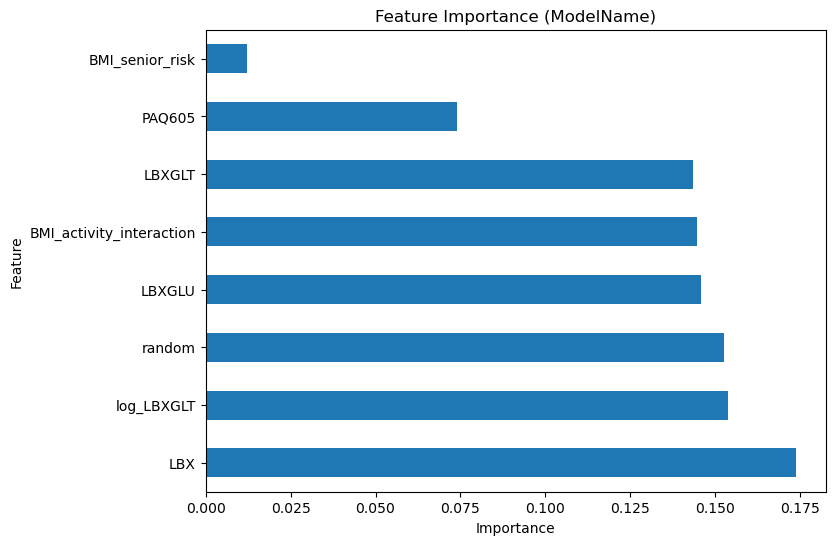

['best_model.pkl']

In [263]:
#without regularisation


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score
import xgboost as xgb
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVC 



models = {
   
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(kernel='rbf', probability=True),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
   # 'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
   # 'KNN': KNeighborsClassifier()
}

best_model = None
best_f1 = 0
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
   
    

    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)  # For binary classification
    results[name] = {'accuracy': acc, 'f1_score': f1}

     
    # Track best model by F1 score
    if f1 > best_f1:
        best_f1 = f1
        best_model = model  # Store the actual model object
        best_model_name = name  # (Optional) Store the name for reporting
    
    print(f"\n{name} Results:")
    print("Accuracy:", acc)
    print("F1 Score:", f1)
    print(classification_report(y_test, preds))

print("\n" + "="*50)
print(f"Best Model by F1 Score: {best_model} (F1 Score: {best_f1:.4f})")
print("="*50)
plot_feature_importance(best_model, X_test, y_test, model_name='ModelName')
joblib.dump(best_model, 'best_model.pkl')

In [264]:
#feature importance

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import numpy as np

def plot_feature_importance(model, X, y, model_name='Model'):
    if hasattr(model, 'feature_importances_'):
        # Tree-based models
        importances = model.feature_importances_
        feat_names = X.columns
    elif hasattr(model, 'coef_'):
        # Linear models like Logistic Regression
        importances = np.abs(model.coef_[0])
        feat_names = X.columns
    else:
        # Models like KNN
        result = permutation_importance(model, X, y, n_repeats=10, random_state=42, scoring='accuracy')
        importances = result.importances_mean
        feat_names = X.columns
    pd.Series(importances, index=feat_names).nlargest(20).plot(kind='barh', figsize=(8,6))
    plt.title(f'Feature Importance ({model_name})')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
 #   print(importances)
    plt.show()


                            PAQ605    LBXGLU    LBXGLT  age_group  log_LBXGLT  \
PAQ605                    1.000000 -0.010292  0.060610   0.156646    0.067951   
LBXGLU                   -0.010292  1.000000  0.666667   0.185035    0.564362   
LBXGLT                    0.060610  0.666667  1.000000   0.305944    0.962012   
age_group                 0.156646  0.185035  0.305944   1.000000    0.340581   
log_LBXGLT                0.067951  0.564362  0.962012   0.340581    1.000000   
LBX                       0.046362  0.797838  0.981246   0.295312    0.924063   
BMI_senior_risk          -0.030438  0.229169  0.184431   0.100094    0.185581   
random                   -0.026929  0.278264  0.211681  -0.088146    0.213008   
BMI_activity_interaction  0.600151  0.175995  0.168670   0.082057    0.173236   

                               LBX  BMI_senior_risk    random  \
PAQ605                    0.046362        -0.030438 -0.026929   
LBXGLU                    0.797838         0.229169  0.2782

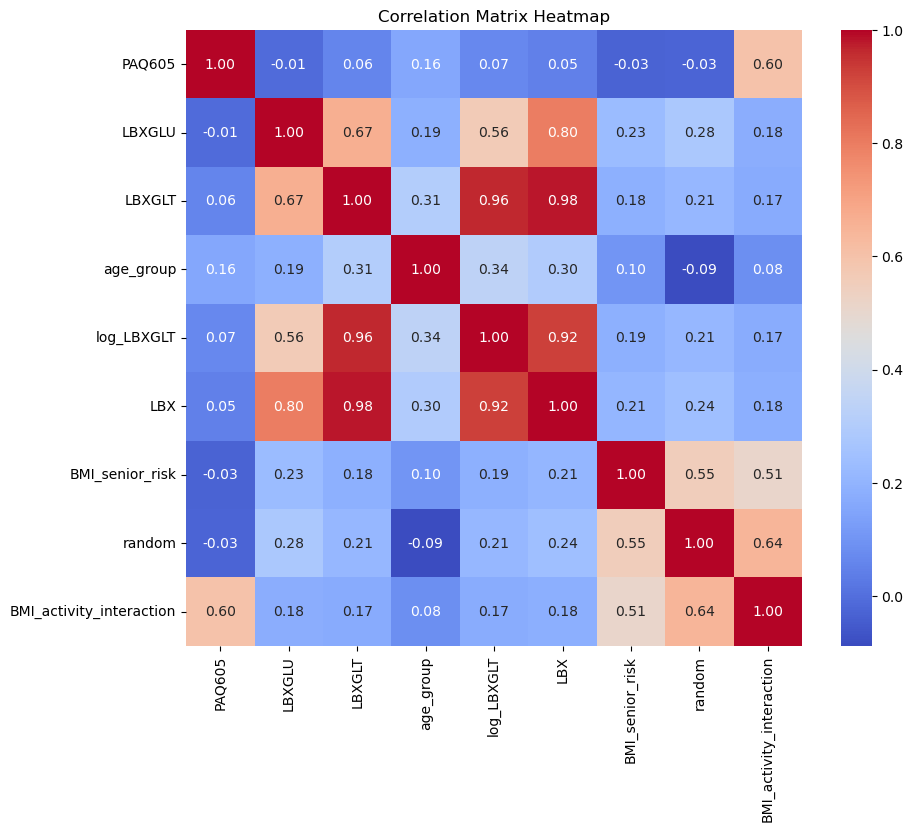

In [265]:
#correlation matrix

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is your DataFrame
corr_matrix = df.corr()
print(corr_matrix)


plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix Heatmap')
plt.show()


In [266]:
# ========== SUBMISSION CODE ========== #
# Load your test data
test_data = pd.read_csv('Test_Data.csv')
print("Test data columns:", test_data.columns.tolist())

# Apply the SAME preprocessing as training data
# 1. Drop columns (only if they exist in test data)
#columns_to_drop = ['DIQ010', 'RIAGENDR', 'BMXBMI']
#existing_columns = [col for col in columns_to_drop if col in test_data.columns]
#if existing_columns:
#    test_data.drop(columns=existing_columns, inplace=True)

# 2. Handle missing values (same as training)
for col in test_data.columns:
    if test_data[col].dtype in ['int64', 'float64'] and col not in ['SEQN', 'age_group']:
        test_data[col] = test_data[col].fillna(test_data[col].mean())

# 3. Apply feature engineering (same as training)


test_data['log_LBXGLT'] = np.log1p(test_data['LBXGLT'])
test_data['LBX']=test_data['LBXGLT']+test_data['LBXGLU']
# Senior risk indicator (BMI >= 25)
test_data['BMI_senior_risk'] = (test_data['BMXBMI'] >= 25).astype(int)
test_data['random']=test_data['DIQ010']+test_data['LBXIN']+test_data['BMXBMI']+test_data['RIAGENDR']

# 3. Interactions (optional, if PAQ605 exists)
if 'PAQ605' in test_data.columns:
    test_data['BMI_activity_interaction'] = test_data['BMXBMI'] * test_data['PAQ605']

# 4. Drop any remaining non-numeric columns except your target
for col in test_data.select_dtypes(include='object').columns:
    if col != 'age_group':  # Keep target if it's still object
        test_data = pd.get_dummies(test_data, columns=[col], prefix=col, drop_first=True)
test_data.drop(columns=['BMXBMI','DIQ010','LBXIN','RIAGENDR'], inplace=True)



# 4. Prepare features (exclude ID and target columns)
X_submission = test_data.drop(columns=['SEQN', 'age_group'], errors='ignore')

print("Final test data shape:", X_submission.shape)
print("Final test data columns:", X_submission.columns.tolist())
#df.columns

# 5. Generate predictions using best model
if isinstance(best_model, Lasso):  # Handle Lasso regression
    preds_proba = best_model.predict(X_submission)
    predictions = (preds_proba > 0.5).astype(int)
else:
    predictions = best_model.predict(X_submission)

# 6. Create submission file
submission_df = pd.DataFrame({
    'age_group': predictions
})

# 7. Save to CSV
submission_df.to_csv('submission.csv', index=False)
print("\nSubmission file 'submission.csv' created successfully!")
print("Submission shape:", submission_df.shape)
print("First 5 predictions:", submission_df.head())


Test data columns: ['SEQN', 'RIAGENDR', 'PAQ605', 'BMXBMI', 'LBXGLU', 'DIQ010', 'LBXGLT', 'LBXIN']
Final test data shape: (312, 8)
Final test data columns: ['PAQ605', 'LBXGLU', 'LBXGLT', 'log_LBXGLT', 'LBX', 'BMI_senior_risk', 'random', 'BMI_activity_interaction']

Submission file 'submission.csv' created successfully!
Submission shape: (312, 1)
First 5 predictions:    age_group
0          0
1          1
2          1
3          0
4          0
